In [1]:
!pip install seaborn matplotlib

In [2]:
import sys
import time
import datetime

In [3]:
TOPIC_Step2_NAME="Sahamyab-Tweets2"
KAFKA_SERVER="kafka-broker:29092"

In [4]:
import os
# https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html

# setup arguments
os.environ['PYSPARK_SUBMIT_ARGS']='--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2 pyspark-shell'

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Step3_1-Visualize-Data") \
    .config("spark.executor.memory", "1024mb") \
    .config("spark.executor.cores","1") \
    .config("spark.cores.max", "1") \
    .config("spark.sql.session.timeZone", "Asia/Tehran") \
    .getOrCreate()    
    
    

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1e2198c7-ff33-453a-8af4-863a6c92155c;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.1.2 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.1.2 in central
	found org.apache.kafka#kafka-clients;2.6.0 in central
	found com.github.luben#zstd-jni;1.4.8-1 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 596ms :: artifacts dl 8ms
	:: modules in use:
	com.github.luben#zstd-jni;1.4.8-1 from central in [default]
	org.apache.commons#commons-pool2;2.6.2 from central in [default]
	

In [5]:
spark.sparkContext.setLogLevel("ERROR")


In [6]:
# https://sparkbyexamples.com/spark/spark-sql-structtype-on-dataframe/
schema = StructType([StructField("id", StringType(), True),\
                         StructField("content", StringType(), True),\
                         StructField("sendTime", StringType(), True),\
                         StructField("sendTimePersian", StringType(), True),\
                         StructField("senderName", StringType(), True),\
                         StructField("senderUsername", StringType(), True),\
                         StructField("type", StringType(), True),\
                         StructField("hashtags", ArrayType(StringType()), True)
                    ])

In [7]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", KAFKA_SERVER) \
  .option("subscribe", TOPIC_Step2_NAME) \
  .option("startingOffsets", "earliest") \
  .option("kafka.group.id", "step3_1-Visualize-Data")\
  .load()

In [8]:
tweetsStringDF = df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

tweetsDF = tweetsStringDF.select(from_json(col("value"), schema).alias("data")).select("data.*")
tweetsDF = tweetsDF.withColumn("timestamp", unix_timestamp("sendTime", "yyyy-MM-dd'T'HH:mm:ss'Z'").cast('timestamp')) \
            .withColumn("persian_timestamp", from_utc_timestamp("timestamp", "Asia/Tehran").cast('timestamp')) \
            .withColumn("persianYear", tweetsDF['sendTimePersian'].substr(0, 4)) \
            .withColumn("persianMonth", tweetsDF['sendTimePersian'].substr(6, 2)) \
            .withColumn("persianDay", tweetsDF['sendTimePersian'].substr(9, 2))


In [9]:
user_activity_count = tweetsDF\
    .withWatermark("persian_timestamp", "10 minutes") \
    .groupBy(
        window(col("persian_timestamp"), "1 hours", "1 hours"), # 10 minute window, updating every 10 minutes
        col("senderUsername"))\
    .count()

In [10]:
# Create query stream with memory sink
queryStream = user_activity_count\
 .writeStream\
 .format("memory")\
 .queryName("user_activity")\
 .outputMode("update")\
 .start()

In [12]:
queryStream.lastProgress

{'id': 'b1a75b38-9e15-404d-9d18-210c603867bd',
 'runId': '55347969-395d-4616-9335-11768ef9c18a',
 'name': 'user_activity',
 'timestamp': '2021-10-06T13:01:46.822Z',
 'batchId': 5,
 'numInputRows': 9,
 'inputRowsPerSecond': 1.3970816516609748,
 'processedRowsPerSecond': 1.4193344898281028,
 'durationMs': {'addBatch': 6250,
  'getBatch': 0,
  'latestOffset': 1,
  'queryPlanning': 52,
  'triggerExecution': 6341,
  'walCommit': 18},
 'eventTime': {'avg': '2021-10-06T12:45:26.222Z',
  'max': '2021-10-06T12:46:29.000Z',
  'min': '2021-10-06T12:44:17.000Z',
  'watermark': '2021-10-06T12:36:29.000Z'},
 'stateOperators': [{'numRowsTotal': 10,
   'numRowsUpdated': 9,
   'memoryUsedBytes': 86376,
   'numRowsDroppedByWatermark': 0,
   'customMetrics': {'loadedMapCacheHitCount': 2000,
    'loadedMapCacheMissCount': 0,
    'stateOnCurrentVersionSizeBytes': 23008}}],
 'sources': [{'description': 'KafkaV2[Subscribe[Sahamyab-Tweets2]]',
   'startOffset': {'Sahamyab-Tweets2': {'0': 411}},
   'endOffset'

**********************
General Info
**********************
Run:6
Stream timestamp:2021-10-06T13:10:37.259Z
Watermark:2021-10-06T12:36:29.000Z
Total Rows:10
Updated Rows:9
Memory used MB:0.086376


**********************
Graph - Top 10 users
**********************


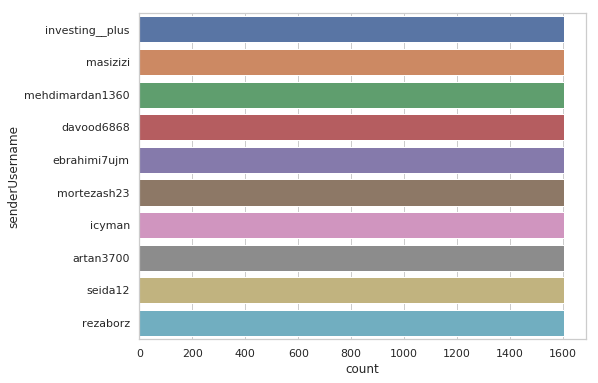

**********************
Table - Top 10 users
**********************


,start,end,senderUsername,count
0,2021-10-06 15:30:00,2021-10-06 16:30:00,investing__plus,1605
1,2021-10-06 15:30:00,2021-10-06 16:30:00,masizizi,1605
2,2021-10-06 15:30:00,2021-10-06 16:30:00,mehdimardan1360,1605
3,2021-10-06 15:30:00,2021-10-06 16:30:00,davood6868,1605
4,2021-10-06 15:30:00,2021-10-06 16:30:00,ebrahimi7ujm,1605
5,2021-10-06 15:30:00,2021-10-06 16:30:00,mortezash23,1605
6,2021-10-06 15:30:00,2021-10-06 16:30:00,icyman,1605
7,2021-10-06 15:30:00,2021-10-06 16:30:00,artan3700,1605
8,2021-10-06 15:30:00,2021-10-06 16:30:00,seida12,1605
9,2021-10-06 15:30:00,2021-10-06 16:30:00,rezaborz,1605


**********************
Table - Count by aggregation window
**********************


,start,end,total_tweets,total_users
0,2021-10-06 15:30:00,2021-10-06 16:30:00,16050,10


process interrupted.


In [13]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
            print("Watermark:{}".format(queryStream.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsUpdated"]))
            print("Memory used MB:{}".format((queryStream.lastProgress["stateOperators"][0]["memoryUsedBytes"]) * 0.000001))
            
        df = spark.sql(
                """
            select
                window.start
                ,window.end
                ,senderUsername
                ,sum(count) as count
            from
                user_activity
            where
                window.start = (select max(window.start) from user_activity)
            group by
                window.start
                ,window.end
                ,senderUsername
            order by
                4 desc
            limit 10
                """
        ).toPandas()

        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        print("**********************")
        print("Graph - Top 10 users")
        print("**********************")
        try:
            # Barplot
            sns.barplot(x="count", y="senderUsername", data=df)

            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        print("**********************")
        print("Table - Top 10 users")
        print("**********************")
        display(df)
        
        print("**********************")
        print("Table - Count by aggregation window")
        print("**********************")
        df1 = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,sum(count) total_tweets
                        ,count(distinct senderUsername) total_users
                    from
                        user_activity
                    group by
                        window.start
                        ,window.end
                    order by
                        window.start desc
                """
        ).toPandas()
        
        display(df1)
        
        sleep(20)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")

In [14]:
queryStream.stop()

21/10/06 13:11:01 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@41e9d65 is aborting.
21/10/06 13:11:01 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@41e9d65 aborted.
